Using TensorFlow backend.


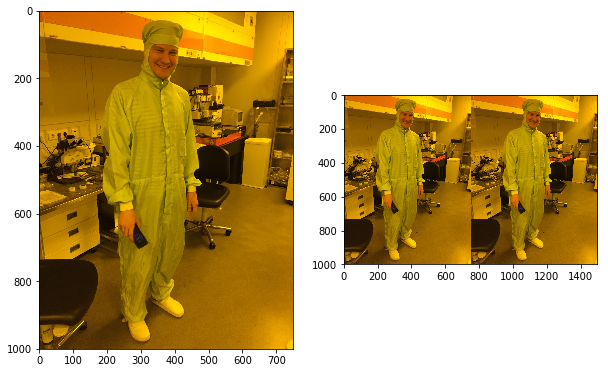

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
sys.path.append('.')

from poseestimation import model

pe = model.PoseEstimator()

img_path = './julian.JPG'

I = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
J = np.hstack([I,I])

# I_list = np.array([I, I])
# print(I_list.shape)




#heatmaps, pafs = pe.predict_pafs_and_heatmaps(J)
positions = pe.predict(I)


fig = plt.figure(figsize=(10,10))
fig.add_subplot(121).imshow(I)
fig.add_subplot(122).imshow(J)
plt.show()

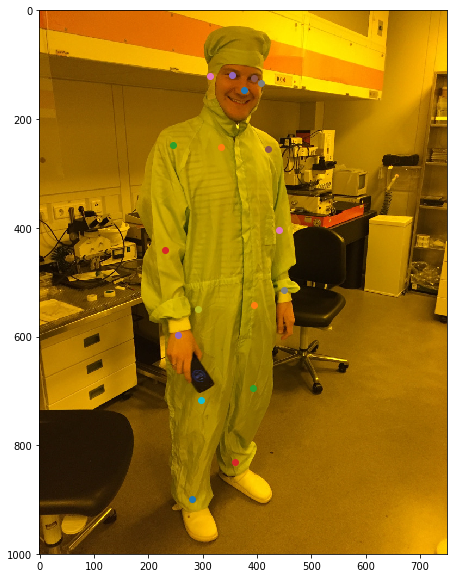

In [2]:
img_pos = positions[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(I)

for x,y in np.squeeze(img_pos):
    ax.scatter(y,x)